## Data mining questions

1- Why a simple linear regression model (without any activation function) is not good for classification task, compared to Perceptron/Logistic regression?

- because linear regression is usually used to predict continuous values but classification is used to predict discrete values, and linear regression is senstive to outliers
- logistic regression is usually used for classification task and A perceptron's used as binary classifier like logistic regression but the difference is that perceptron uses step activation function.
- both logistic regression and preceptron are better than linear regression in classification task.

---


2- What's a decision tree and how it is different to a logistic regression model?

- A decision tree is a supervised machine learning that categorizes or predicts outcomes based on the answers to a previous set of questions.

- It has a tree-like structure with branches and nodes that represent different outcomes or decisions

The difference between decision tree and logistic regression is that 
- logistic regression assumes that the data is linearly separable in space
- decision tree is a*non-linear classifier
- Decision trees can handle categorical data better, while logistic regression can handle continuous data better

---


3- What's the difference between grid search and random search?

- Grid search tries every possible hyperparameter combination to find the best one, but it is very slow to run
- Random search randomly picks hyperparameter combinations from a grid and evaluates the model performance. It is faster than grid search, but it may not find the optimal hyperparameters

---

4- What's the difference between bayesian search and random search?

- Bayesian search is an optimization algorithm that sequentially uses a model-based approach to determine the next hyperparameter value based on the results of the previous iteration.
- Random search uses a grid of hyperparameter values and selects random combinations for training and scoring the model.
- In terms of finding the best hyperparameters, Bayesian search outperforms random search and is faster than grid search

## problem formulation
</br>

### problem definition

- building a machine learning model to predict the probability (0-1, float) (output) that the dating session will match. 

- inputs : (191 features) for both training set (5909 observations) and test set (2469 observations) 

- output : (1 feature) for train set (5909 observations) as output.

---

### Data mining function
- classification and prediction

---

### Challenges

- that our dataset has a lot of null values 

- that the is an imbalanced dataset a lot 0's and less of 1's


---

### Model impact

- It help people to meet their suitable partners 

---

### The ideal solution

- Using a XGBClassifierr with grid search to search for the best hyperparameters combinations to get better ROC-AUC result (88.184%)


## Experimental protocol

### Data preprocessing
---
- building a pipeline which will do some preprocessing for the features.
- using imputer with mean strategy for numeric values and constant for categorical values to impute missing values 
- using standard scaling

---
### Building models

- creating search spaces (random, bayesian and grid)
- training each model many times with different hyperparameters and choose the best
- Start predicting the test data

At the end i tried deep nural network with hyperparameter tunning but the accuracy was a bit lower than xgboost it was about 0.85166 and the xgb was 0.88517 on public leaderboard

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler , StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier #bagging
from xgboost.sklearn import XGBClassifier #boosting
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skopt.space import Categorical ,Integer ,Real
from sklearn.pipeline import Pipeline
from pandas.core.arrays import numeric
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

# Data preprocessing

In [102]:
df1 = pd.read_csv('train.csv',index_col='id')
df2 = pd.read_csv('test.csv',index_col='id')
print(df1.shape)
print(df2.shape)
df = pd.concat([df1,df2])
df= df.drop(['pid'],axis=1)
df

(5909, 191)
(2469, 190)


,gender,idg,condtn,wave,round,position,positin1,order,partner,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2583,0,3,2,14,18,2,2.0,14,12,0.0,-0.03,0,27.0,2.0,30.00,15.00,15.00,20.00,5.00,15.00,7.0,7.0,7.0,6.0,5.0,NaN,7.0,1.0,2.0,33.0,Ed.D. in higher education policy at TC,9.0,University of Michigan-Ann Arbor,"1,290.00","21,645.00",3.0,2.0,1.0,"Palo Alto, CA",NaN,NaN,1.0,6.0,3.0,University President,2.0,3.0,4.0,4.0,10.0,9.0,10.0,1.0,1.0,8.0,7.0,10.0,8.0,10.0,1.0,4.0,10.0,4.0,2.0,NaN,40.00,15.00,25.00,5.00,15.00,0.00,55.0,10.0,5.0,15.0,5.0,10.0,70.00,5.00,5.00,15.00,5.00,0.00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,6.0,5.0,7.0,6.0,6.0,NaN,6.0,4.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,10.0,10.0,10.0,10.0,0.0,45.0,25.0,5.0,25.0,0.0,0.0,65.00,5.00,5.00,25.00,0.00,0.00,10.0,10.0,10.0,9.0,10.0,10.0,9.0,10.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6830,1,14,1,3,10,2,NaN,8,8,0.0,0.21,0,24.0,4.0,5.00,15.00,45.00,25.00,0.00,10.00,3.0,8.0,5.0,3.0,7.0,1.0,1.0,3.0,2.0,22.0,Engineering,5.0,NaN,NaN,NaN,2.0,8.0,1.0,"Boston, MA","2,021",NaN,5.0,6.0,1.0,Engineer or iBanker or consultant,7.0,8.0,3.0,7.0,10.0,6.0,6.0,7.0,2.0,9.0,5.0,6.0,7.0,7.0,6.0,8.0,8.0,4.0,7.0,9.0,21.00,20.00,19.00,20.00,10.00,10.00,NaN,NaN,NaN,NaN,NaN,NaN,30.00,15.00,10.00,20.00,10.00,15.00,7.0,9.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,5.0,8.0,8.0,5.0,7.0,6.0,6.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,17.0,17.0,17.0,10.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,7.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,20.00,20.00,15.00,20.00,10.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN
4840,1,14,1,13,10,8,8.0,10,10,0.0,0.43,0,34.0,2.0,15.00,15.00,10.00,25.00,10.00,25.00,4.0,8.0,7.0,4.0,7.0,3.0,3.0,2.0,2.0,27.0,Urban Planning,5.0,"Rizvi College of Architecture, Bombay University",NaN,NaN,6.0,1.0,1.0,"Bombay, India",NaN,NaN,1.0,4.0,2.0,Real Estate Consulting,7.0,4.0,2.0,7.0,6.0,8.0,8.0,8.0,6.0,6.0,8.0,4.0,10.0,10.0,7.0,7.0,5.0,10.0,2.0,NaN,10.00,20.00,25.00,20.00,20.00,5.00,25.0,5.0,20.0,25.0,10.0,15.0,25.00,10.00,20.00,25.00,10.00,10.00,7.0,9.0,7.0,9.0,10.0,7.0,9.0,9.0,7.0,9.0,6.0,5.0,7.0,5.0,7.0,6.0,6.0,5.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0

In [103]:
df.dtypes.value_counts()

float64    173
int64        9
object       8
dtype: int64

In [104]:
df.isna().sum().sum()

434474

In [105]:
df.select_dtypes(include=['object'])

,field,undergra,mn_sat,tuition,from,zipcode,income,career
id,,,,,,,,
2583,Ed.D. in higher education policy at TC,University of Michigan-Ann Arbor,"1,290.00","21,645.00","Palo Alto, CA",NaN,NaN,University President
6830,Engineering,NaN,NaN,NaN,"Boston, MA","2,021",NaN,Engineer or iBanker or consultant
4840,Urban Planning,"Rizvi College of Architecture, Bombay University",NaN,NaN,"Bombay, India",NaN,NaN,Real Estate Consulting
5508,International Affairs,NaN,NaN,NaN,"Washington, DC","10,471","45,300.00",public service
4828,Business,Harvard College,"1,400.00","26,019.00",Midwest USA,"66,208","46,138.00",undecided
...,...,...,...,...,...,...,...,...
7982,Neuroscience and Education,Columbia,"1,430.00","26,908.00",Hong Kong,0,NaN,Academic
7299,School Psychology,Bucknell University,"1,290.00","25,335.00","Erie, PA",NaN,NaN,school psychologist
1818,Law,NaN,NaN,NaN,Brooklyn,"11,204","26,482.00",Intellectual Property Attorney


In [106]:
df['match'].value_counts().sort_values()

1.0     988
0.0    4921
Name: match, dtype: int64

In [107]:
df['mn_sat'].value_counts(dropna=False)

NaN         5245
1,400.00     403
1,430.00     262
1,290.00     190
1,450.00     163
1,340.00     146
1,309.00     138
1,260.00     133
1,360.00     116
1,460.00     100
1,330.00      84
1,310.00      80
1,188.00      80
1,210.00      61
1,380.00      61
1,250.00      53
1,130.00      43
1,160.00      42
1,258.00      42
1,320.00      42
1,030.00      40
1,242.00      36
1,200.00      34
1,206.00      33
1,110.00      30
1,155.00      30
1,090.00      29
1,410.00      27
1,402.00      24
1,227.00      22
1,280.00      22
1,239.00      22
1,050.00      21
1,149.00      21
1,308.00      21
1,100.00      21
1,220.00      21
1,490.00      21
990           20
1,159.00      20
1,365.00      19
1,011.00      19
1,105.00      19
1,370.00      19
1,180.00      18
1,140.00      18
1,157.00      18
1,014.00      18
1,341.00      18
1,331.00      18
1,060.00      18
1,097.00      14
1,092.00      14
1,212.00      14
1,034.00      14
1,185.00      14
1,270.00      10
1,470.00      10
1,178.00      

In [108]:
#remove some string
df.mn_sat = df.mn_sat.str.replace((","), (""))
#convert it to float
df[["mn_sat"]] = df[["mn_sat"]].astype(float)
df.mn_sat = df.mn_sat.fillna(df.mn_sat.mean())
df['mn_sat'].value_counts(dropna=False)

1299.655282    5245
1400.000000     403
1430.000000     262
1290.000000     190
1450.000000     163
1340.000000     146
1309.000000     138
1260.000000     133
1360.000000     116
1460.000000     100
1330.000000      84
1310.000000      80
1188.000000      80
1210.000000      61
1380.000000      61
1250.000000      53
1130.000000      43
1160.000000      42
1258.000000      42
1320.000000      42
1030.000000      40
1242.000000      36
1200.000000      34
1206.000000      33
1110.000000      30
1155.000000      30
1090.000000      29
1410.000000      27
1402.000000      24
1227.000000      22
1280.000000      22
1239.000000      22
1050.000000      21
1149.000000      21
1308.000000      21
1100.000000      21
1220.000000      21
1490.000000      21
990.000000       20
1159.000000      20
1365.000000      19
1011.000000      19
1105.000000      19
1370.000000      19
1180.000000      18
1140.000000      18
1157.000000      18
1014.000000      18
1341.000000      18
1331.000000      18


In [109]:
df['from'].value_counts(dropna=False).sort_values()

Greenwich, CT                                                   5
Europe                                                          5
Pougkeepsie NY                                                  5
sofia, bg                                                       5
china                                                           5
Pittsburgh, PA                                                  6
india                                                           6
Manila, Philippines                                             6
Santa Barbara, California                                       6
TN                                                              6
Kansas City, Missouri                                           7
Boston, Ma                                                      7
Upstate New York                                                7
Greece/Germany                                                  8
Portland, Oregon                                                9
Great Neck

In [110]:
df['from'] = df['from'].fillna(df['from'].mode()[0])
df['from'] = df['from'].str.upper()

In [111]:
df['from'].value_counts(dropna=False).sort_values()

GREENWICH, CT                                                   5
POUGKEEPSIE NY                                                  5
EUROPE                                                          5
SOFIA, BG                                                       5
MANILA, PHILIPPINES                                             6
TN                                                              6
SANTA BARBARA, CALIFORNIA                                       6
PITTSBURGH, PA                                                  6
KANSAS CITY, MISSOURI                                           7
UPSTATE NEW YORK                                                7
GREECE/GERMANY                                                  8
TORONTO, LONDON, INDIA                                          9
WESTCHESTER, NEW YORK                                           9
ERIE, PA                                                        9
TOKYO AND TEXAS                                                 9
LEXINGTON,

In [112]:
df.income = df.income.str.replace((","), (""))
#convert it to float
df[["income"]] = df[["income"]].astype(float)
df.income = df.income.fillna(df.income.mean())
df['income'].value_counts(dropna=False)

44887.60645     4099
55080.00000      124
53229.00000       41
25401.00000       39
78704.00000       37
49409.00000       37
33772.00000       37
80006.00000       34
69487.00000       30
52010.00000       29
16767.00000       28
58802.00000       26
35627.00000       22
46272.00000       22
50572.00000       22
20000.00000       22
47624.00000       22
32386.00000       22
41191.00000       22
71787.00000       22
46280.00000       22
48137.00000       22
36510.00000       22
55138.00000       22
36673.00000       22
32508.00000       22
61686.00000       22
30038.00000       22
49642.00000       22
15863.00000       22
72412.00000       22
46608.00000       21
26706.00000       21
25786.00000       21
37240.00000       21
53196.00000       21
73073.00000       21
62997.00000       21
43844.00000       21
31432.00000       21
77112.00000       21
80608.00000       21
18283.00000       21
37881.00000       21
48944.00000       21
36594.00000       21
50060.00000       21
30146.00000  

In [113]:
df['field_cd'] = df['field_cd'].fillna(18)
df['race'] = df['race'].fillna(6)
df['race_o'] = df['race_o'].fillna(6)
df['career_c'] = df['career_c'].fillna(15)
df['field_cd'] = df['field_cd'].fillna(18)
df['goal'] = df['goal'].fillna(6)

In [114]:
df[['gender','from','field_cd','career_c','goal','race_o','samerace','wave','position','order','condtn']].isna().sum()

gender      0
from        0
field_cd    0
career_c    0
goal        0
race_o      0
samerace    0
wave        0
position    0
order       0
condtn      0
dtype: int64

In [115]:
print(df.shape)
# df[['gender','from','field_cd','career_c','goal','race_o','samerace','wave','position','order','condtn']] = df[['gender','from','field_cd','career_c','goal','race_o','samerace','wave','position','order','condtn']].astype('category')
# df = pd.get_dummies(df, columns = ['gender','from','field_cd','career_c','goal','race_o','samerace','wave','position','order','condtn'],prefix=['gender','from', 'field_cd', 'career_c', 'goal','race_o','samerace','wave','position','order','condtn'],drop_first=True)
df.shape

(8378, 190)


(8378, 190)

In [116]:
df.dtypes.value_counts()

float64    175
int64        9
object       6
dtype: int64

In [117]:
df[df.select_dtypes(['uint8']).columns] = df.select_dtypes(['uint8']).apply(lambda x: x.astype('int64'))
df.dtypes.value_counts()

float64    175
int64        9
object       6
dtype: int64

In [118]:
df.isna().sum().sum()

424616

In [119]:
# df.loc[:, df.isna().mean() > 0.7]

In [120]:
# # I will remove features that is null values inside it is more than 70% in total.
# df3= df.drop(df.loc[:, df.isna().mean() > 0.7].columns,axis=1)

In [121]:
# df.columns.difference(df3.columns)

In [122]:
# df3.isna().sum().sum()

In [123]:
# df3

In [124]:
# features_numeric=list(df.drop(['match'], axis=1).select_dtypes(include=['float64','int64']))
# for col in features_numeric:
#     df[col].fillna(df[col].mean(), inplace=True)

In [125]:
df.isna().sum().sum()

424616

In [126]:
# df3

In [127]:
print(df1.shape)
print(df2.shape)

(5909, 191)
(2469, 190)


In [128]:
# cat_cols = df.select_dtypes(include=['object']).columns
# for col in cat_cols:


In [129]:
obj_ts=df.select_dtypes(include=['object']) 

#categorical encoding of all object data
for i in obj_ts:
    df[i]=df[i].astype("category")

In [130]:
train=df[df["match"].notna()]
test=df[df["match"].isna()]
test=test.drop(['match'], axis=1)

In [131]:
print(train.shape)
print(test.shape)

(5909, 190)
(2469, 189)


In [132]:
# split our training data into X and Y to use them in SMOTE..
# X , Y = train[train.columns[train.columns != 'match']], train[train.columns[train.columns == 'match']]

In [133]:
# Y.value_counts()

In [134]:
# smote = SMOTE(k_neighbors=3)
# X_train, y_train = smote.fit_resample(X , Y)

In [135]:
X_train=train.drop(['match'], axis=1)
y_train=train.match

In [136]:
from collections import Counter
print(sorted(Counter(y_train).items()))

[(0.0, 4921), (1.0, 988)]


In [137]:
from imblearn.over_sampling import RandomOverSampler
# RandomOverSampleris used to solve unbalanced data so the number of 1's equals the number of 0's.
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0.0, 4921), (1.0, 4921)]


In [138]:
print(X_train.shape)
print(y_train.shape)

(9842, 189)
(9842,)


In [139]:
features_numeric=list(X_train.select_dtypes(include=['float64','int64']))

#put categoric features in feature_cat list
features_cat=list(X_train.select_dtypes(include=['category']))
features_cat

['field', 'undergra', 'tuition', 'from', 'zipcode', 'career']

In [40]:
from pandas.core.arrays import numeric

# Create a pipline for numerical features and select it's hyperparameters
numeric=Pipeline(
    steps=[
           ('imputer', SimpleImputer(strategy='mean')), # SimpleImputer used to handel missing value and have strategy='mean' is default val that means fill nan value with mean
           ('scaler', StandardScaler())  # StandardScaler used to scale number
    ]
)

categorical=Pipeline(
    steps=[
           ('imputer',SimpleImputer(strategy='constant')), # SimpleImputer used to handel missing value and have strategy='constant' that means fill nan value with constant
            ('onehot',OneHotEncoder(handle_unknown='ignore'))# OneHotEncoder used to encode categorical data
    ]
)
# ColumnTransformer used to construct and apply separate numerical and categorical data transformers.
# Select and prepare the columns of the dataset before fitting a model to the modified data.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric, features_numeric),# Numerical data
        ('cat', categorical, features_cat) # Categorical data
    ]
)
# Put the preprocessing a siutable classifier.
full_piplinex = Pipeline(  
    steps=[
        ('preprocessor', preprocessor), 
        ('my_classifier', 
           XGBClassifier(), # I used XGBClassifier as a classifier.
        )
    ]
)
full_piplinex
full_pipliner = Pipeline(  
    steps=[
        ('preprocessor', preprocessor), 
        ('my_classifier', 
           RandomForestClassifier(), # I used RandomForestClassifier as a classifier.
        )
    ]
)
full_pipliner
np.random.seed(0)  # used to make the random numbers predictable


In [41]:
# Fitting and predict The pipeline object.
full_piplinex = full_piplinex.fit(X_train, y_train)
full_piplinex.predict(test)

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
unique_values, counts = np.unique(full_piplinex.predict(test), return_counts=True)
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

0: 2065
1: 404


#  Trial 1 (random search xgboost)

In [43]:
#define parameter grid for XGBoost
xgb_param = {
  'my_classifier__n_estimators': [200,400,450, 500],
  'my_classifier__max_depth': [15,30,60,70,80],
  'my_classifier__learning_rate': [0.01, 0.1, 0.2],
  'my_classifier__gamma': [0, 0.1, 0.2],
  'my_classifier__subsample': [0.8, 0.9, 1]
}

xgb_random = RandomizedSearchCV(full_piplinex, xgb_param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)
xgb_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_f

In [44]:
#get best parameters
xgb_random.best_params_ #{'subsample': 1, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0}

{'my_classifier__subsample': 1,
 'my_classifier__n_estimators': 500,
 'my_classifier__max_depth': 15,
 'my_classifier__learning_rate': 0.1,
 'my_classifier__gamma': 0}

In [45]:
#get best scores
xgb_random.best_score_ #0.998419207128341

0.9985143830108445

#  Trial 2 (bayes search xgboost)

In [46]:
xgb_param_bayes = {
  'my_classifier__n_estimators': Categorical([100, 200,400,450, 500]),
  'my_classifier__max_depth': Integer(3,100),
  'my_classifier__learning_rate':Real(1e-5, 0.2, prior='log-uniform'),
  'my_classifier__gamma':Real(1e-5, 0.2, prior='log-uniform'),
  'my_classifier__subsample':Real(0.5, 1, prior='log-uniform')
}

xgb_bayes = BayesSearchCV(full_piplinex, xgb_param,n_iter=20, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)
xgb_bayes.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_f

In [47]:
#get best parameters
xgb_bayes.best_params_ #([('gamma', 0.1), ('learning_rate', 0.1), ('max_depth', 15), ('n_estimators', 400), ('subsample', 0.8)])

OrderedDict([('my_classifier__gamma', 0.0),
             ('my_classifier__learning_rate', 0.1),
             ('my_classifier__max_depth', 15),
             ('my_classifier__n_estimators', 400),
             ('my_classifier__subsample', 0.8)])

In [48]:
#get best scores
xgb_bayes.best_score_#0.9984186305513699

0.9986586863129372

#  Trial 3 (random search random forest)

In [49]:
#define parameter grid for random forest
rf_param = {
    'my_classifier__n_estimators': [100,200,400,450,500],
    'my_classifier__max_depth': [10,20,30,60,80],
    'my_classifier__max_features': ['auto', 'sqrt', 'log2'],
    'my_classifier__criterion': ['gini', 'entropy'],
    'my_classifier__min_samples_split':[2,4,6,8]
}



#create grid search objects
rf_random = RandomizedSearchCV(full_pipliner,rf_param, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc').fit(X_train, y_train)
#get best models
rf_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_f

In [50]:
#get best parameters
rf_random.best_params_ #{'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini'}

{'my_classifier__n_estimators': 500,
 'my_classifier__min_samples_split': 2,
 'my_classifier__max_features': 'sqrt',
 'my_classifier__max_depth': 30,
 'my_classifier__criterion': 'gini'}

In [51]:
#get best scores
rf_random.best_score_ #0.9993813290305738

0.9993445872686101

#  Trial 4 (Bayes search random forest)

In [52]:
rf_param_bayes = {
    'my_classifier__n_estimators': Categorical([50,100, 200,400, 500]),
    'my_classifier__max_depth': Integer(3,100),
    'my_classifier__max_features': Categorical(['auto', 'sqrt', 'log2']),
    'my_classifier__criterion': Categorical(['gini', 'entropy']),
    'my_classifier__min_samples_split':Integer(3,10)
}
#create grid search objects
rf_bayes = BayesSearchCV(full_pipliner,rf_param, cv=5, n_jobs=-1, verbose=1,n_iter=20, scoring='roc_auc').fit(X_train, y_train)
#get best models
rf_bayes.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_f

In [53]:
rf_bayes.best_params_#{'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'entropy'}

OrderedDict([('my_classifier__criterion', 'gini'),
             ('my_classifier__max_depth', 60),
             ('my_classifier__max_features', 'sqrt'),
             ('my_classifier__min_samples_split', 2),
             ('my_classifier__n_estimators', 100)])

In [54]:
#get best scores
rf_bayes.best_score_#0.9993976376973596

0.9992529328150159

#  Trial 5 (grid search random forest)

In [55]:
#create grid search objects
rf_param_grid = {
    'my_classifier__n_estimators': [400,450,500],
    'my_classifier__max_depth': [10,15,30,60],
    'my_classifier__max_features': ['auto', 'sqrt', 'log2'],
    'my_classifier__criterion': ['gini', 'entropy'],
    'my_classifier__min_samples_split':[6,8,10,12]
}
rf_grid = GridSearchCV(full_pipliner,rf_param_grid, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc').fit(X_train, y_train)#get best models
rf_grid.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_f

In [56]:
rf_grid.best_params_#{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 500}

{'my_classifier__criterion': 'entropy',
 'my_classifier__max_depth': 60,
 'my_classifier__max_features': 'auto',
 'my_classifier__min_samples_split': 6,
 'my_classifier__n_estimators': 500}

In [57]:
#get best scores
rf_grid.best_score_#0.8669025721211645

0.9979769942957569

#  Trial 6 (grid search xgboost)

In [58]:
xgb_param_grid = {
  'my_classifier__n_estimators': [400,450, 500,600],
  'my_classifier__max_depth': [5,8,10,15,30,60],
  'my_classifier__learning_rate': [0.01, 0.1, 0.2],
  'my_classifier__gamma': [0, 0.1, 0.2],
  'my_classifier__subsample': [0.8, 0.9, 1]
}

xgb_grid = GridSearchCV(full_piplinex, xgb_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)
xgb_grid.best_estimator_

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_f

In [59]:
xgb_grid.best_params_#{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 600, 'subsample': 0.8}

{'my_classifier__gamma': 0,
 'my_classifier__learning_rate': 0.1,
 'my_classifier__max_depth': 15,
 'my_classifier__n_estimators': 450,
 'my_classifier__subsample': 0.8}

In [60]:
#get best scores
xgb_grid.best_score_#0.88691989366169

0.9986863477477786

In [61]:
# pred_test = xgb_bayes.predict(test)
# pred_df = pd.DataFrame(data={'id': test.index, 'match': pred_test})
# pred_df.to_csv("xgb_bayes_pipeline_no_delete.csv",index=False)

### Best model was xgboost with gridsearch and got 0.88517 on kaggle public leaderboard

In [140]:
submission = pd.DataFrame()

submission['id'] = test.index

submission['match'] = xgb_grid.predict_proba(test)[:,1]

submission.to_csv('xgb_grid final prob.csv', index=False)

In [63]:
# pred_test2 = rf_random.predict(test)
# pred_df2 = pd.DataFrame(data={'id': test.index, 'match': pred_test2})
# pred_df2.to_csv("rf_random_pipeline_no_delete.csv",index=False)

In [64]:
# pred_test3 = xgb_grid.predict(test)
# pred_df = pd.DataFrame(data={'id': test.index, 'match': pred_test3})
# pred_df.to_csv("xgb_grid_pipeline_no_delete.csv",index=False)

# Deep Nueral Network

In [65]:
from keras.layers.core import Dense
from keras.layers import Dropout
from tensorflow import keras
from keras.models import Sequential
from keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
import keras_tuner as kt
from imblearn.over_sampling import SMOTE

In [66]:
df

,gender,idg,condtn,wave,round,position,positin1,order,partner,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2583,0,3,2,14,18,2,2.0,14,12,0.0,-0.03,0,27.0,2.0,30.00,15.00,15.00,20.00,5.00,15.00,7.0,7.0,7.0,6.0,5.0,NaN,7.0,1.0,2.0,33.0,Ed.D. in higher education policy at TC,9.0,University of Michigan-Ann Arbor,1290.000000,"21,645.00",3.0,2.0,1.0,"PALO ALTO, CA",NaN,44887.60645,1.0,6.0,3.0,University President,2.0,3.0,4.0,4.0,10.0,9.0,10.0,1.0,1.0,8.0,7.0,10.0,8.0,10.0,1.0,4.0,10.0,4.0,2.0,NaN,40.00,15.00,25.00,5.00,15.00,0.00,55.0,10.0,5.0,15.0,5.0,10.0,70.00,5.00,5.00,15.00,5.00,0.00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,6.0,5.0,7.0,6.0,6.0,NaN,6.0,4.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,10.0,10.0,10.0,10.0,0.0,45.0,25.0,5.0,25.0,0.0,0.0,65.00,5.00,5.00,25.00,0.00,0.00,10.0,10.0,10.0,9.0,10.0,10.0,9.0,10.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6830,1,14,1,3,10,2,NaN,8,8,0.0,0.21,0,24.0,4.0,5.00,15.00,45.00,25.00,0.00,10.00,3.0,8.0,5.0,3.0,7.0,1.0,1.0,3.0,2.0,22.0,Engineering,5.0,NaN,1299.655282,NaN,2.0,8.0,1.0,"BOSTON, MA","2,021",44887.60645,5.0,6.0,1.0,Engineer or iBanker or consultant,7.0,8.0,3.0,7.0,10.0,6.0,6.0,7.0,2.0,9.0,5.0,6.0,7.0,7.0,6.0,8.0,8.0,4.0,7.0,9.0,21.00,20.00,19.00,20.00,10.00,10.00,NaN,NaN,NaN,NaN,NaN,NaN,30.00,15.00,10.00,20.00,10.00,15.00,7.0,9.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,5.0,8.0,8.0,5.0,7.0,6.0,6.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,17.0,17.0,17.0,10.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,7.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,20.00,20.00,15.00,20.00,10.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN
4840,1,14,1,13,10,8,8.0,10,10,0.0,0.43,0,34.0,2.0,15.00,15.00,10.00,25.00,10.00,25.00,4.0,8.0,7.0,4.0,7.0,3.0,3.0,2.0,2.0,27.0,Urban Planning,5.0,"Rizvi College of Architecture, Bombay University",1299.655282,NaN,6.0,1.0,1.0,"BOMBAY, INDIA",NaN,44887.60645,1.0,4.0,2.0,Real Estate Consulting,7.0,4.0,2.0,7.0,6.0,8.0,8.0,8.0,6.0,6.0,8.0,4.0,10.0,10.0,7.0,7.0,5.0,10.0,2.0,NaN,10.00,20.00,25.00,20.00,20.00,5.00,25.0,5.0,20.0,25.0,10.0,15.0,25.00,10.00,20.00,25.00,10.00,10.00,7.0,9.0,7.0,9.0,10.0,7.0,9.0,9.0,7.0,9.0,6.0,5.0,7.0,5.0,7.0,6.0,6.0,5.0,0.0,4.0,NaN,NaN,Na

In [67]:
features_numeric=list(df.drop(['match'], axis=1).select_dtypes(include=['float64','int64']))
for col in features_numeric:
    df[col].fillna(df[col].mean(), inplace=True)

In [68]:
obj_ts=df.select_dtypes(include=['object']) 

#categorical encoding of all object data
for i in obj_ts:
    df[i].fillna('Unknown', inplace=True)

In [69]:
df.isna().sum().sum()

11944

In [70]:
df[['gender','from','field_cd','career_c','goal','race_o','samerace','wave','position','order','condtn']] = df[['gender','from','field_cd','career_c','goal','race_o','samerace','wave','position','order','condtn']].astype('category')
df = pd.get_dummies(df, columns = ['field', 'undergra', 'tuition', 'zipcode', 'career','gender','from','field_cd','career_c','goal','race_o','samerace','wave','position','order','condtn'],prefix=['field', 'undergra', 'tuition', 'zipcode', 'career','gender','from', 'field_cd', 'career_c', 'goal','race_o','samerace','wave','position','order','condtn'],drop_first=True)


In [71]:
df.shape

(8378, 1910)

In [72]:
# train[train.select_dtypes(['uint8']).columns] = train.select_dtypes(['uint8']).apply(lambda x: x.astype('int64'))
# train.dtypes.value_counts()

In [73]:
# #put categoric features in feature_cat list
# features_cat=list(train.select_dtypes(include=['category']))
# features_cat

In [74]:
scaler = StandardScaler()
#extract integer columns
intcol = df.select_dtypes(include='int64').columns
#normlize integer columns
df[intcol] = scaler.fit_transform(df[intcol])
floatcol = df.select_dtypes(include='float64').drop(['match'], axis=1).columns
#normalize float columns
df[floatcol] = scaler.fit_transform(df[floatcol])

In [75]:
train=df[df["match"].notna()]
test=df[df["match"].isna()]
test=test.drop(['match'], axis=1)

In [76]:
X_train=train.drop(['match'], axis=1)
y_train=train.match

In [77]:
test

idg     round  positin1   partner      int_corr         age_o  \
id                                                                         
934  -1.126789 -0.200093  0.000000  0.735129 -1.084367e+00 -1.515003e+00   
6539  1.432607  0.258812 -0.660654 -0.175495 -2.528221e-01 -6.678436e-01   
6757 -1.035382  0.717717  1.343894  1.827878 -2.860839e-01  1.793157e-01   
2275  0.792758  0.488265  0.000000  0.188755 -2.860839e-01 -9.502300e-01   
1052  1.066979 -0.200093 -0.460199 -0.721869  8.448176e-01  1.793157e-01   
...        ...       ...       ...       ...           ...           ...   
7982  0.518537  0.488265  1.744804  0.370880  1.809410e+00 -6.678436e-01   
7299 -1.126789 -1.806261 -1.061564 -0.175495 -6.462404e-16 -1.003238e-15   
1818  0.792758  0.488265  0.000000 -1.086119 -1.084367e+00 -1.515003e+00   
937   0.152909  0.717717  0.341620 -1.268243  7.782939e-01 -1.030707e-01   
6691  1.889642  1.176622 -0.460199 -0.721869  4.789377e-01 -9.502300e-01   

          pf_o_att      pf_o_sin      pf_o_int      pf_o_fun      pf_o_amb  \
id                                                                           
934  -5.995268e-01  3.715542e-01 -7.812739e-01  2.072958e+00 -9.340305e-01   
6539 -1.995941e-01 -1.055780e+00  7.010059e-01  4.199193e-01 -1.125979e-01   
6757 -6.563173e-01  1.388986e-01 -2.817456e-01 -1.867461e-01  1.262480e+00   
2275 -9.994595e-01  3.715542e-01 -4.013404e-02  4.199193e-01  1.530267e+00   
1052 -5.819298e-01 -3.107117e-01 -1.038721e-01 -1.152396e-02  3.868330e-01   
...            ...           ...           ...           ...           ...   
7982  6.002712e-01 -3.421131e-01 -7.812739e-01 -4.066003e-01  7.088346e-01   
7299  1.136677e-15 -1.267728e-14 -9.479008e-15 -9.983717e-15 -7.587618e-15   
1818 -9.994595e-01  3.715542e-01  2.924426e+00 -1.233120e+00 -1.125979e-01   
937  -6.083253e-01  2.502307e-01  1.495978e-01  2.794109e-01  6.907631e-01   
6691 -1.995941e-01  3.715542e-01 -4.013404e-02  4.199193e-01 -9.340305e-01   

          pf_o_sha    attr_o    sinc_o   intel_o     fun_o     amb_o  \
id                                                                     
934   4.996002e-01  0.420488 -0.102465 -0.899774 -0.209571 -0.453904   
6539  4.996002e-01  0.420488  1.066854  0.414435  0.836719  0.129213   
6757  3.871372e-01 -0.098897 -0.102465  0.414435  0.313574  0.712331   
2275 -2.923928e-01 -1.657052 -0.102465  0.414435 -0.209571  0.129213   
1052  1.223482e+00 -0.618282 -0.102465 -0.242670 -0.732717  1.295448   
...            ...       ...       ...       ...       ...       ...   
7982 -2.923928e-01 -0.098897  0.482194  1.728644  0.313574  1.295448   
7299 -8.441172e-15  0.939873 -0.687125 -0.242670  1.359865  0.129213   
1818 -2.923928e-01 -0.098897 -0.687125 -1.556879  0.313574 -1.037021   
937  -1.910177e-01 -0.098897  0.482194 -0.242670 -1.255862 -1.037021   
6691  4.996002e-01  0.939873 -3.025763 -1.556879 -0.732717 -1.037021   

        shar_o    like_o    prob_o     met_o       age        mn_sat  \
id                                                                     
934  -0.235924 -0.625596 -1.536208  0.165637 -1.511145  3.104201e-15   
6539  0.757712 -0.074166  0.857944  0.165637  0.180774  5.644555e-01   
6757  0.757712 -0.074166  0.379114  0.165637  0.180774  3.104201e-15   
2275 -0.235924  0.477264  0.857944  0.165637 -1.511145  3.104201e-15   
1052  0.260894 -0.074166 -0.578547  0.165637  1.026733  3.104201e-15   
...        ...       ...       ...       ...       ...           ...   
7982 -1.229560 -0.074166 -0.099717  0.165637  1.026733  1.779521e+00   
7299  0.757712  1.580124  0.379114  0.165637 -0.947172 -1.318180e-01   
1818  0.260894 -0.074166 -0.099717  0.165637 -1.511145  3.104201e-15   
937  -0.235924 -1.177026 -0.578547  0.165637 -1.229159  3.104201e-15   
6691 -0.235924 -0.625596 -1.536208  0.165637  0.462760  3.104201e-15   

          race   imprace  imprelig        income      date    go_out  \
id                                                           

In [78]:
X_train=train.drop(['match'], axis=1)
y_train=train.match

In [79]:
from imblearn.over_sampling import RandomOverSampler
# RandomOverSampleris used to solve unbalanced data so the number of 1's equals the number of 0's.
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0.0, 4921), (1.0, 4921)]


In [80]:
X_train.shape

(9842, 1909)

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify=y_train,test_size = 0.2,random_state=1)

In [82]:
# X_train, X_val, y_train, y_val= train_test_split(X_res, Y_res,stratify=Y_res,test_size = 0.1,random_state=1) 

In [87]:
keras.backend.clear_session()  #removing weights

def create_MLP(hp):
  #learning rate
    LR = hp.Float('learning_rate',min_value=1e-4,max_value=0.1,sampling='log')
  #hidden units number
    hidden_neurons = hp.Int('hidden_units',min_value=32,max_value=512*3,step=32)
  #dropout rate
    hidden_dropout =  hp.Float('hidden_dropout',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
  #l1 reguralization
    l1_penalty_hidden = hp.Float('l1_penalty_hidden',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)
  #l2 reguralization
    l2_penalty_hidden = hp.Float('l2_penalty_hidden',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)
  #l2 reguralization for hidden layer bias
    l2_penalty_hidden_bias = hp.Float('l2_penalty_hidden_bias',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)
  
  #creating model
    MLP = Sequential()
    MLP.add(Dense(units=hidden_neurons,input_dim=1909,kernel_regularizer=regularizers.l1_l2(l1=l1_penalty_hidden, l2=l2_penalty_hidden),
                  bias_regularizer=regularizers.l2(l2_penalty_hidden_bias), activation='relu'))#input + hidden layer
    MLP.add(Dropout(rate = hidden_dropout))   # dropout layer
    MLP.add(Dense(1, activation='sigmoid'))   #Output layer
    optimizer = Adam(learning_rate=LR)
    MLP.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])   #multiclass
    MLP.build(X_train.shape)
    print(MLP.summary())
    return MLP

In [88]:
#The overwrite=True parameter in the KerasTuner constructor is used to indicate that the tuner should start a new search and ignore any previous results
tuner = kt.Hyperband(create_MLP,objective='val_accuracy',max_epochs=300,overwrite = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                61120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 61,153
Trainable params: 61,153
Non-trainable params: 0
_________________________________________________________________
None


In [89]:
#callback function that stops the training of a neural network model when a monitored metric has stopped improving
#patience parameter is the number of epochs with no improvement after which training will be stopped
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

In [90]:
#search for best hyperparameters to find best validation accuracy
#use_multiprocessing=True and workers=5 indicate that the generator is run in parallel to the model with 6 processes.
tuner.search(X_train, y_train, epochs=300, validation_data=(X_val,y_val), use_multiprocessing=True, workers=20, callbacks=[early_stop])

# Get the optimal hyperparameters after finishing the search
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] #get the number 1 best hyperparametes

Trial 725 Complete [00h 00m 07s]
val_accuracy: 0.8059929013252258

Best val_accuracy So Far: 0.950736403465271
Total elapsed time: 00h 56m 15s
INFO:tensorflow:Oracle triggered exit


In [91]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0002672620042049546
hidden_units: 352
hidden_dropout: 0.0
l1_penalty_hidden: 0.0
l2_penalty_hidden: 0.0
l2_penalty_hidden_bias: 0.0045000000000000005
tuner/epochs: 300
tuner/initial_epoch: 100
tuner/bracket: 5
tuner/round: 5
tuner/trial_id: 0422
Score: 0.950736403465271
Trial summary
Hyperparameters:
learning_rate: 0.0011395358173931997
hidden_units: 192
hidden_dropout: 0.45
l1_penalty_hidden: 0.0
l2_penalty_hidden: 0.0
l2_penalty_hidden_bias: 0.006
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0580
Score: 0.9476891756057739
Trial summary
Hyperparameters:
learning_rate: 0.0002672620042049546
hidden_units: 352
hidden_dropout: 0.0
l1_penalty_hidden: 0.0
l2_penalty_hidden: 0.0
l2_penalty_hidden_bias: 0.0045000000000000005
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 5
tuner/round: 4
tuner/trial_id: 0415
Score: 0.947181

In [92]:
# Get the optimal 10 hyperparameters after finishing the search
best_hps=tuner.get_best_hyperparameters(num_trials=15)[:]

best_hidden_units = []
best_learning_rates = []
best_hidden_l2 = []
best_hidden_l1 = []
best_hidden_l2_bias = []
best_dropout_rate = []
for i in range(15):
    best_hidden_units.append(best_hps[i].get('hidden_units'))
    best_learning_rates.append(best_hps[i].get('learning_rate'))
    best_hidden_l2.append(best_hps[i].get('l2_penalty_hidden'))
    best_hidden_l1.append(best_hps[i].get('l1_penalty_hidden'))
    best_hidden_l2_bias.append(best_hps[i].get('l2_penalty_hidden_bias'))
    best_dropout_rate.append(best_hps[i].get('hidden_dropout'))
#     best_score.append(best_hps[i].get('Score'))

best_hps = pd.DataFrame({'Learning rate':best_learning_rates, 
                            'Best hidden units number':best_hidden_units,
                            'Best hidden units L2':best_hidden_l2,
                            'Best hidden L1':best_hidden_l1,
                            'Best hidden L2 bias':best_hidden_l2_bias,
                            'Best Dropout Rate':best_dropout_rate})
#                             'Best Score':best_score})

best_hps.drop_duplicates(inplace=True)
best_hps.reset_index(drop=True,inplace=True)
best_hps

,Learning rate,Best hidden units number,Best hidden units L2,Best hidden L1,Best hidden L2 bias,Best Dropout Rate
0,0.000267,352,0.0,0.0,0.0045,0.00
1,0.001140,192,0.0,0.0,0.0060,0.45
2,0.002441,288,0.0,0.0,0.0000,0.10
3,0.001409,736,0.0,0.0,0.0030,0.25
4,0.000100,864,0.0,0.0,0.0075,0.45
5,0.001348,640,0.0,0.0,0.0030,0.30


In [93]:
def build_model(best_values):

    keras.backend.clear_session()
    MLP = Sequential()
    MLP.add(Dense(units=best_values[1],input_dim=X_train.shape[1],kernel_regularizer=regularizers.l1_l2(l1=best_values[3], l2=best_values[2]),bias_regularizer=regularizers.l2(best_values[4]), activation='relu'))
    MLP.add(Dropout(rate = best_values[5]))
    MLP.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=best_values[0])
    MLP.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    MLP.build(X_train.shape)
    return MLP

In [94]:
def train_all_models(models):

    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    for i in range(len(models)):
        keras.backend.clear_session()
        history = models[i].fit(X_train, y_train, epochs=300,batch_size = 64, validation_data=(X_val,y_val),callbacks=[early_stop],verbose = 0)
        val_loss_per_epoch = history.history['val_loss']
        loss_per_epoch = history.history['loss']
        val_accuracy_per_epoch = history.history['val_accuracy']
        accuracy_per_epoch = history.history['accuracy']
        plt.figure(figsize=(8,8))
        plt.title(f"model number {i+1} training loss & validation")
        plt.xlabel('epoch')
        plt.ylabel('loss function')
        plt.plot(np.arange(1,len(val_loss_per_epoch)+1),val_loss_per_epoch,label="validation loss")
        plt.plot(np.arange(1,len(loss_per_epoch)+1),loss_per_epoch,label = "training loss")
        plt.legend(loc="upper left")
        plt.show()
        plt.figure(figsize=(8,8))
        plt.title(f"model number {i+1} training accuracy & validation accuracy")
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.plot(np.arange(1,len(val_accuracy_per_epoch)+1),val_accuracy_per_epoch,label="validation accuracy")
        plt.plot(np.arange(1,len(accuracy_per_epoch)+1),accuracy_per_epoch,label = "training accuracy")
        plt.legend(loc="upper left")
        plt.show()

In [95]:
def evaluate_model(models,X_tr,X_val,y_tr,y_val):
    training_loss = []
    validation_loss =[]
    training_accuracy = []
    validation_accuracy = []
    #get the training and validation loss/accuracy for best 12 models
    for i in range(len(models)):
        keras.backend.clear_session()
        training_accuracy.append(models[i].evaluate(X_tr, y_tr)[0])
        validation_accuracy.append(models[i].evaluate(X_val,y_val)[0])
    return training_loss, validation_loss, training_accuracy, validation_accuracy

In [96]:
def createBest_12Models(best_hyperparameters):
    models = []
    for i in range(len(best_hyperparameters)):
        models.append(build_model(best_hyperparameters.iloc[i]))
    return models

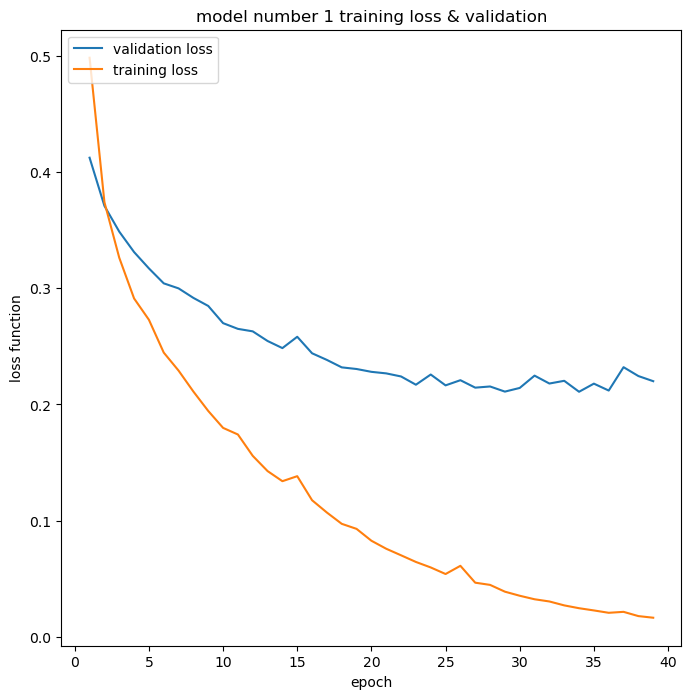

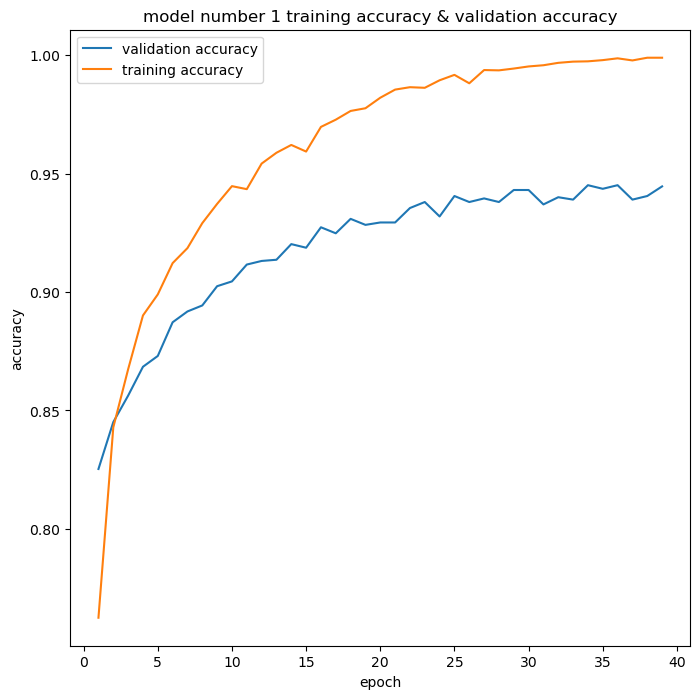

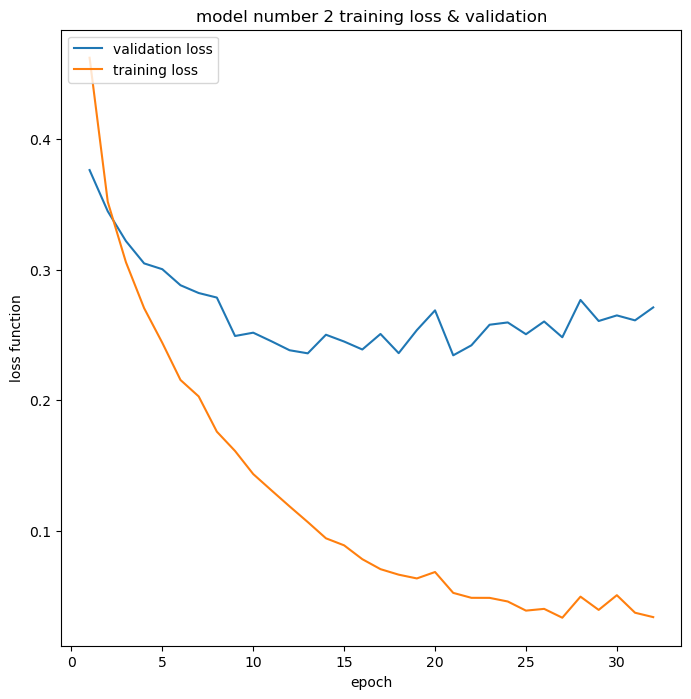

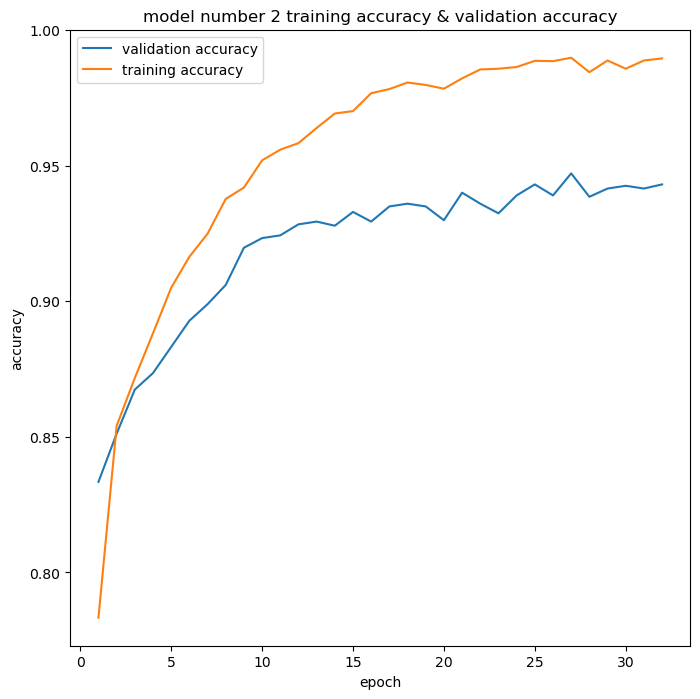

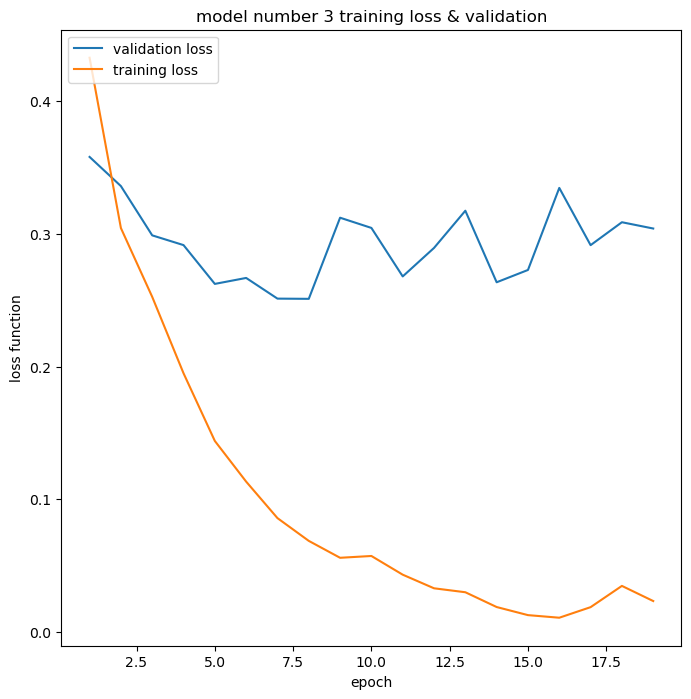

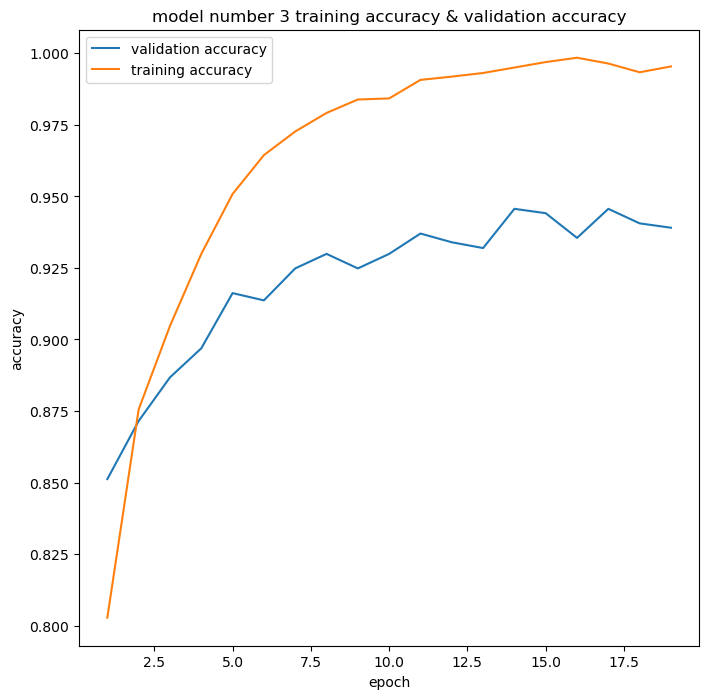

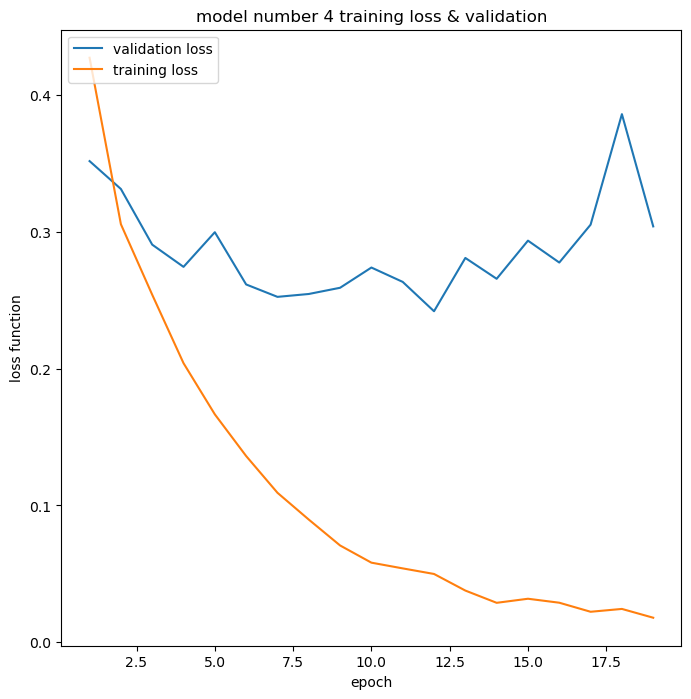

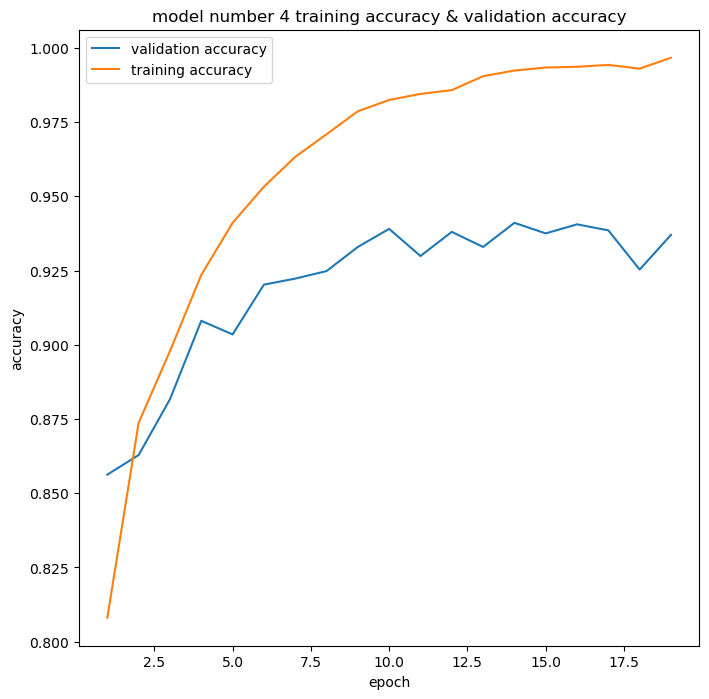

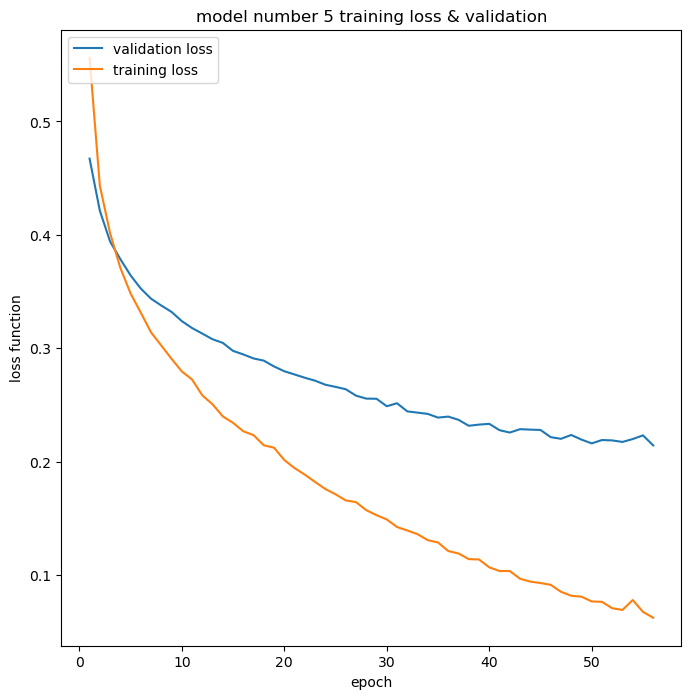

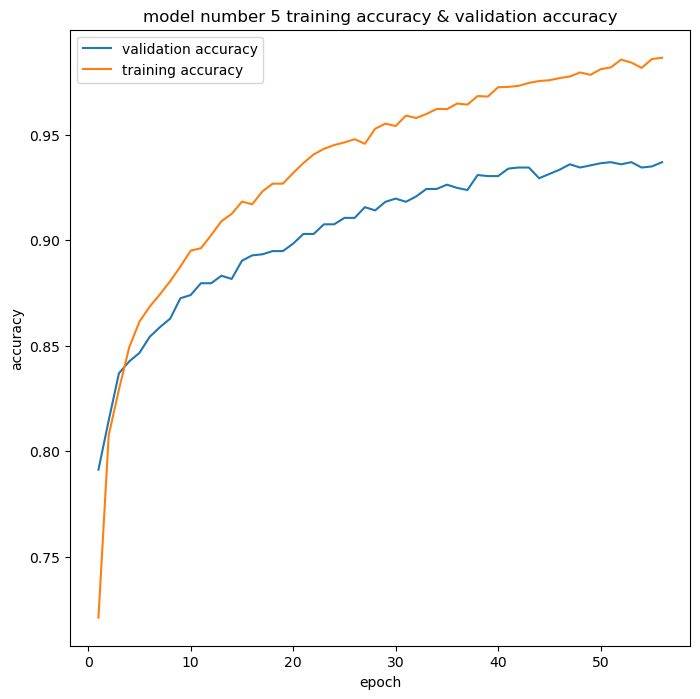

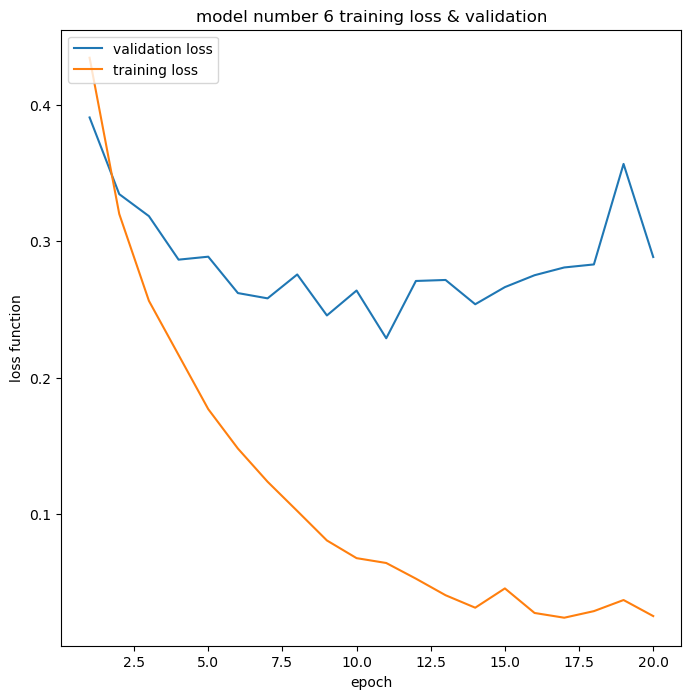

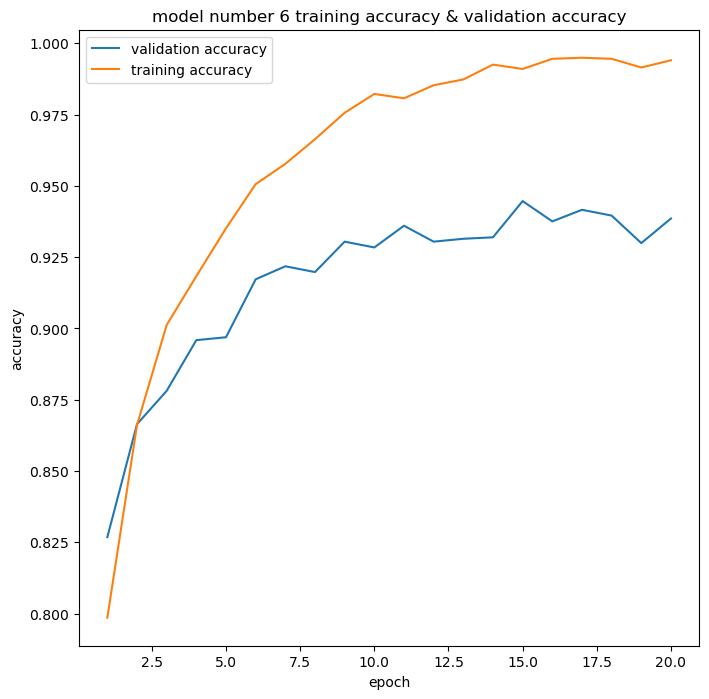

62/62 [==============================] - 0s 2ms/step - loss: 0.2885 - accuracy: 0.9385


In [97]:
models = createBest_12Models(best_hps)
train_all_models(models)
avg_training_loss_1, avg_validation_loss_1, avg_training_accuracy_1, avg_validation_accuracy_1 = evaluate_model(models,X_train,X_val,y_train,y_val)

In [ ]:
# 5 	0.000460	128	0.0015	0.0	0.0060	0.00   0.8954 0.9484

In [98]:
pred_test = models[0].predict(test)

pred_df = pd.DataFrame(data={'id': test.index, 'match': pred_test.flatten()})
pred_df.to_csv("DNN2 finale prob.csv",index=False)

78/78 [==============================] - 0s 1ms/step


In [ ]:
# pred_df['match'].value_counts()

In [ ]:
# pred_test = (pred_test >= 0.5).astype(int)

In [ ]:
# pred_test
# pred_df = pd.DataFrame(data={'id': test.index, 'match': pred_test.flatten()})
# pred_df['match'].value_counts()

# 